<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/8_3D_DENSNET(MONAI)_CBAM_BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

shivakumarullagaddi_dataset_nifiti2_path = kagglehub.dataset_download('shivakumarullagaddi/dataset-nifiti2')

print('Data source import complete.')


#Binary Classification
#3D DenseNet for MRI Classification in PyTorch

0 → CN (Not Alzheimer's)

1 → AD (Alzheimer's)


## output:
>Accuracy	0.74  <br/>
>ROC AUC	0.841<br/>
>Best Class Recall	AD (0.89) <br/>
>Best Class Precision	CN (0.84)<br/>


**Problem :**
            

> model is little overfitting

> Model Generalization is Poor

>Missing SEGMENTATION {use Freesurfer or Fastsurfer}

**learnings :**
>3D images needs more compution (GPUs) TAKES MORE TIME WITH CPU</br>

>Whenever Dataset is SMALL and model is Overfitting : use DATA AGUMENTATION ,REGULARZIATION

>Whenever problem with Genralization : use Transfer Learning

>Whenever problem in loading huge dataset ,while training in GPU : use mixed Precision

>When all good : Try to change and observe epoch,batch size,learning rate



Imports and Setup

In [ ]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found ex

In [ ]:
import monai
monai.config.print_config()


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-07-06 06:34:05.917621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751783646.132700      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751783646.191581      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.5.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#inst

In [ ]:
!pip install nibabel scipy

import os
import random
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# from torchvision.models.video import densenet121  #for DenseNet121 2d from torchvision
from monai.networks.nets import DenseNet121       #for DenseNet121 3d from monai

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
from scipy.ndimage import zoom

from torch.amp import autocast, GradScaler

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Multi-GPU device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name(s):", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])


CUDA available: True
CUDA device count: 2
Device name(s): ['Tesla T4', 'Tesla T4']


 Data Augmentation Function

In [ ]:
def augment_volume(volume):
    if random.random() > 0.5:
        volume = np.flip(volume, axis=0)
    if random.random() > 0.5:
        volume = np.flip(volume, axis=1)
    if random.random() > 0.5:
        volume = np.flip(volume, axis=2)
    k = random.choice([0,1,2,3])
    axis = random.choice([(0,1),(1,2),(0,2)])
    volume = np.rot90(volume, k=k, axes=axis)
    noise = np.random.normal(0, 0.01, volume.shape)
    volume = volume + noise
    volume = np.clip(volume, 0, 1)
    return volume


MRI3DDataset

In [ ]:
class MRI3DDataset(Dataset):
    def __init__(self, samples, target_shape=(128, 128, 128), augment=False):
        self.samples = samples
        self.target_shape = target_shape
        self.augment = augment
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        nii_path, label = self.samples[idx]
        img = nib.load(nii_path).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = self.resize_volume(img, self.target_shape)
        if self.augment:
            img = augment_volume(img)
        img = img[np.newaxis, ...].astype(np.float32)
        return torch.tensor(img), label
    def resize_volume(self, volume, target_shape):
        depth, height, width = volume.shape
        target_depth, target_height, target_width = target_shape
        depth_factor = target_depth / depth
        height_factor = target_height / height
        width_factor = target_width / width
        return zoom(volume, (depth_factor, height_factor, width_factor), order=1)


Data Preparation

In [ ]:
root_dir = '/kaggle/input/dataset-nifiti2/DATASET_NIFTI2'  # Update as needed
class_names = ['AD', 'CN']
class_map = {'CN': 0, 'AD': 1}
random.seed(42)

train_samples, val_samples, test_samples = [], [], []
for cls in class_names:
    class_dir = os.path.join(root_dir, cls)
    nii_files = [f for f in os.listdir(class_dir) if f.endswith(('.nii', '.nii.gz'))]
    random.shuffle(nii_files)
    n_total = len(nii_files)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val
    for file_list, sample_list in zip([nii_files[:n_train],
                                       nii_files[n_train:n_train+n_val],
                                       nii_files[n_train+n_val:]],
                                      [train_samples, val_samples, test_samples]):
        for nii_file in file_list:
            nii_path = os.path.join(class_dir, nii_file)
            sample_list.append((nii_path, class_map[cls]))


Data Loaders (Batch Size 16, Augmentation for Training)

In [ ]:
# Try a large batch size; reduce if you get CUDA OOM errors
batch_size = 4  # Try 8, 16, or even 32 if your data fits in 30GB VRAM
target_shape = (128, 128, 128)
train_dataset = MRI3DDataset(train_samples, target_shape, augment=True)
val_dataset = MRI3DDataset(val_samples, target_shape, augment=False)
test_dataset = MRI3DDataset(test_samples, target_shape, augment=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Model (Multi-GPU with DataParallel)  (optional made by shiva)

In [ ]:
class DenseNet3D_MRI(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super().__init__()
        self.model = DenseNet121(
            spatial_dims=3,
            in_channels=1,
            out_channels=num_classes,
            pretrained=pretrained
        )
    def forward(self, x):
        return self.model(x)

model = DenseNet3D_MRI(num_classes=2, pretrained=False)
model = torch.nn.DataParallel(model)  # Use all GPUs
model = model.to(device)
print("Model device:", next(model.parameters()).device)


Model device: cuda:0


check

In [ ]:

print(torch.cuda.is_available())
print(torch.cuda.device_count())


True
2


In [ ]:
!nvidia-smi


Sun Jul  6 06:34:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             25W /   70W |     167MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Training Loop (GPU-Only, Multi-GPU, Mixed Precision)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scaler = GradScaler()
num_epochs = 12
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for i, (volumes, labels) in enumerate(train_loader):
        volumes, labels = volumes.to(device, non_blocking=True),labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(volumes)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * volumes.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i == 0:
            print("Batch device check:", volumes.device, labels.device, outputs.device)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for volumes, labels in val_loader:
            volumes, labels = volumes.to(device, non_blocking=True), torch.tensor(labels).to(device, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(volumes)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs}: Loss={running_loss/len(train_loader.dataset):.4f} "
          f"Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")

    # Monitor GPU usage
    if epoch == 0 or epoch == num_epochs - 1:
        os.system('nvidia-smi')


Batch device check: cuda:0 cuda:0 cuda:0


/tmp/ipykernel_35/3421520369.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volumes, labels = volumes.to(device, non_blocking=True), torch.tensor(labels).to(device, non_blocking=True)


Epoch 1/12: Loss=0.7011 Train Acc=53.08% Val Acc=61.86%
Sun Jul  6 06:40:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P0             29W /   70W |    2621MiB /  15360MiB |      2%      Default |
|                                         |                        |                

 Evaluation

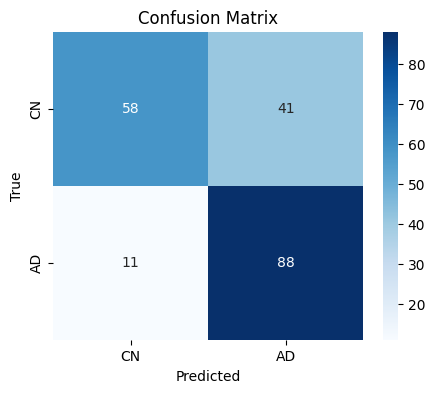

              precision    recall  f1-score   support

          CN       0.84      0.59      0.69        99
          AD       0.68      0.89      0.77        99

    accuracy                           0.74       198
   macro avg       0.76      0.74      0.73       198
weighted avg       0.76      0.74      0.73       198



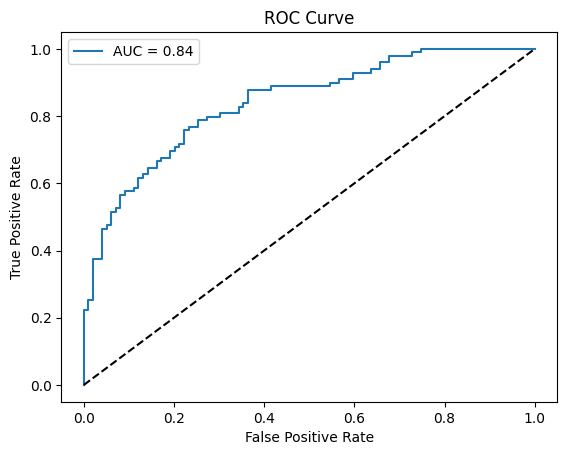

ROC AUC: 0.841


In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()
all_preds, all_targets, all_probs = [], [], []
with torch.no_grad():
    for volumes, labels in test_loader:
        volumes = volumes.to(device)
        outputs = model(volumes)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["CN", "AD"],
            yticklabels=["CN", "AD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_targets, all_preds, target_names=["CN", "AD"]))

auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print(f"ROC AUC: {auc:.3f}")


Visualization


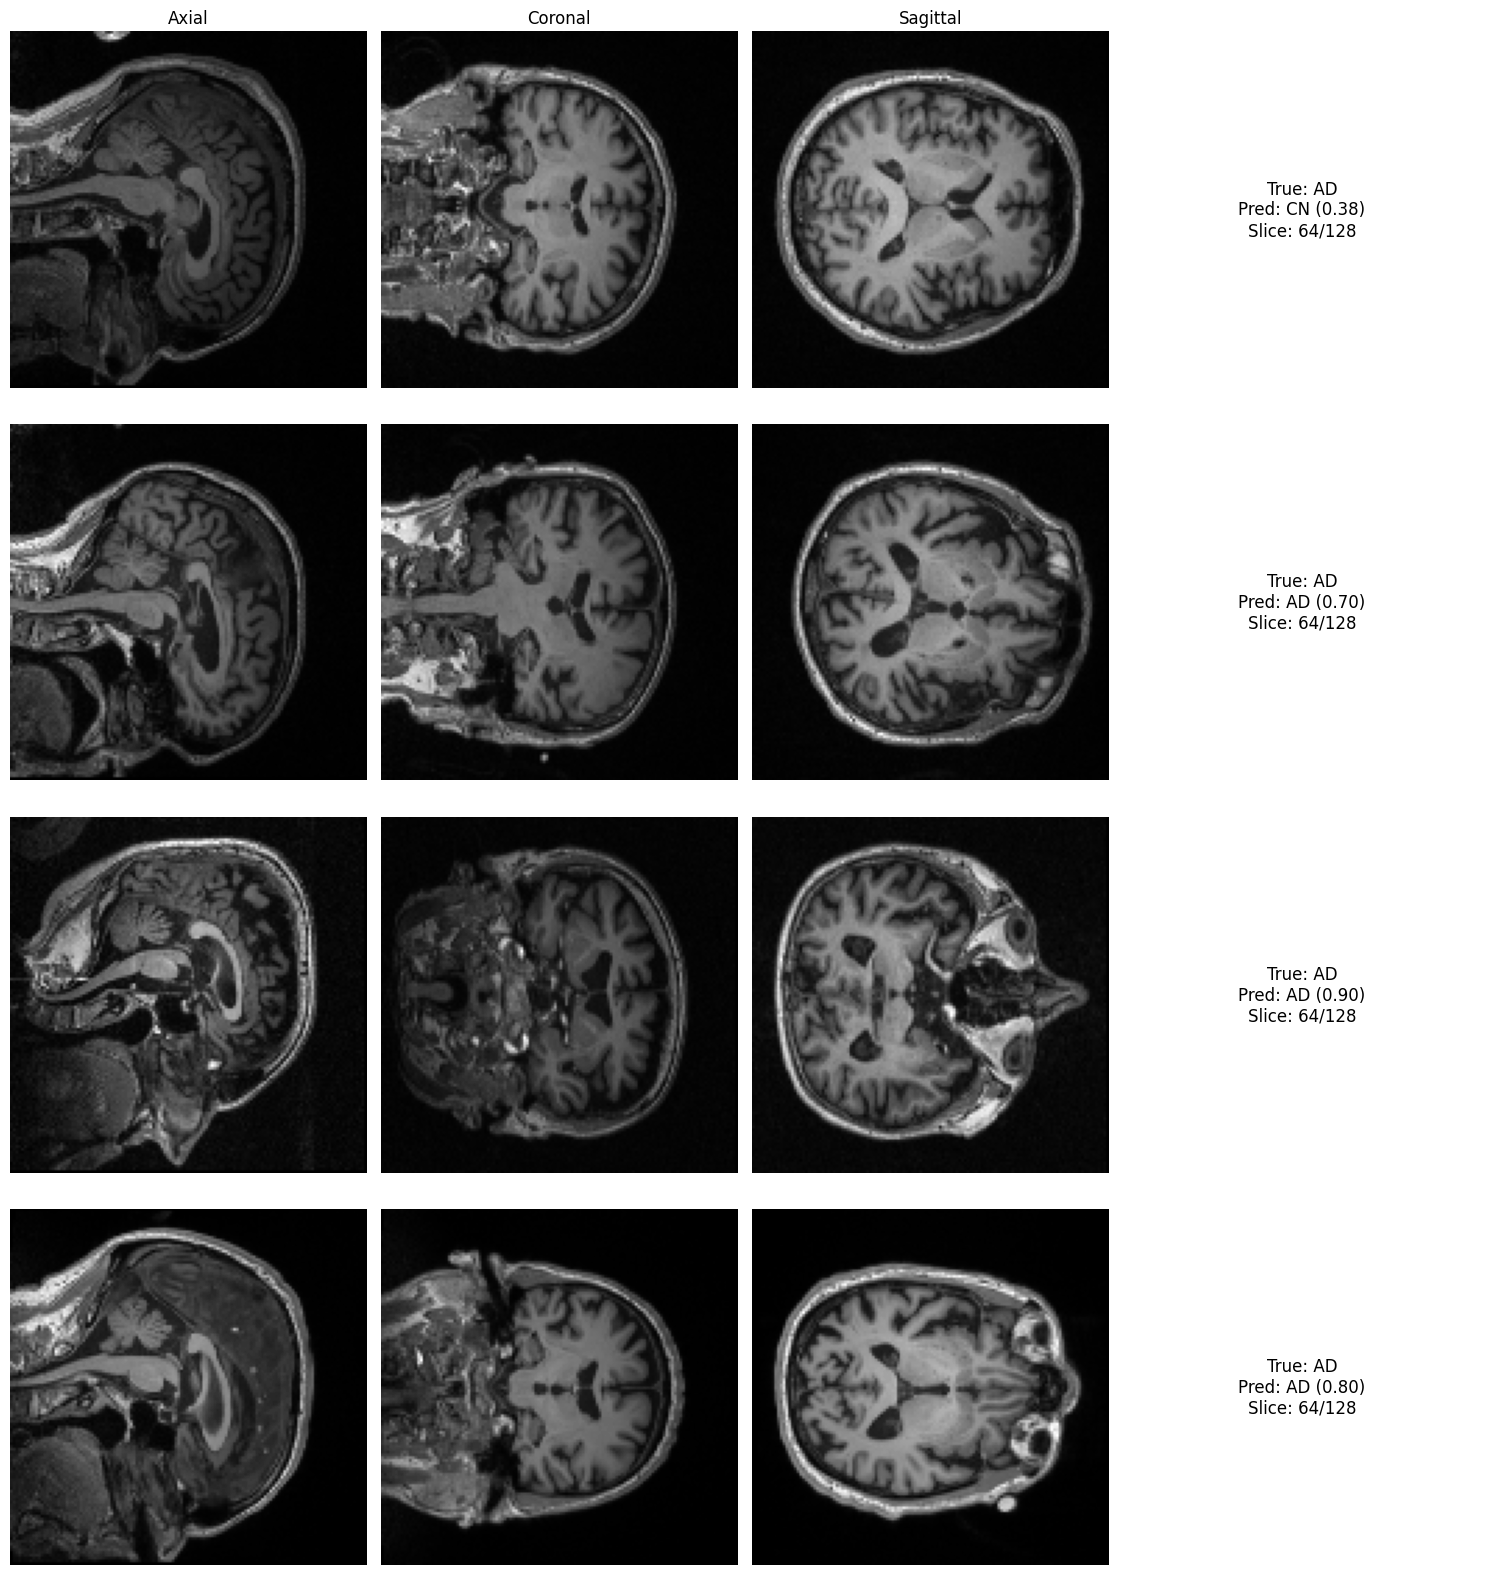

In [ ]:
num_examples = 4
fig, axes = plt.subplots(num_examples, 4, figsize=(15, 4*num_examples))

for idx in range(num_examples):
    volume, label = test_dataset[idx]
    volume = volume.numpy()[0]  # Remove channel dim

    # Show orthogonal slices
    mid_z = volume.shape[0] // 2
    mid_y = volume.shape[1] // 2
    mid_x = volume.shape[2] // 2

    slices = [
        volume[mid_z, :, :],  # Axial
        volume[:, mid_y, :],   # Coronal
        volume[:, :, mid_x]    # Sagittal
    ]

    # Get model prediction
    with torch.no_grad():
        input_tensor = torch.tensor(volume[np.newaxis, np.newaxis, ...]).to(device)
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)[0, 1].item()
        pred = 1 if prob > 0.5 else 0

    # Plot slices
    for j, slice_img in enumerate(slices):
        ax = axes[idx, j]
        ax.imshow(slice_img, cmap='gray')
        ax.axis('off')
        if idx == 0:
            ax.set_title(['Axial','Coronal','Sagittal'][j])

    # Add prediction info
    ax = axes[idx, 3]
    ax.text(0.5, 0.5,
            f"True: {'AD' if label == 1 else 'CN'}\n"
            f"Pred: {'AD' if pred == 1 else 'CN'} ({prob:.2f})\n"
            f"Slice: {mid_z}/{volume.shape[0]}",
            ha='center', va='center', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()
